<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_private/blob/main/Simple_Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How to Develop a 1D Generative Adversarial Network From Scratch in Keras**

Code from:
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

In [20]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense, Flatten
from matplotlib import pyplot

import numpy as np


In [21]:

# length of the input vector
vec_length=16


define the standalone discriminator model

In [22]:

# define the standalone discriminator model
def define_discriminator(n_inputs=2*vec_length):
  model = Sequential()
  model.add(Flatten(input_dim=n_inputs))
  model.add(Dense(20, activation='relu', kernel_initializer='he_uniform')) #25
  model.add(Dense(20, activation='relu', kernel_initializer='he_uniform'))
#  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


define the standalone generator model

In [23]:

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2*vec_length):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim)) #15
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(n_outputs, activation='linear'))
	return model


define the combined generator and discriminator model, for updating the generator

In [24]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model


generate n real samples with class labels

In [25]:

# generate n real samples with class labels
def generate_real_samples(n):
  #print("generate ",n)

  X = np.zeros(shape=(n,2,vec_length))
  for i in range(0,n):
    x1 = np.linspace(0,1,vec_length) + 0.1*randn(vec_length)
    x2 = 2.*(np.random.randint(2, size=1)-0.5)*x1 + 0.1*randn(vec_length)
    X[i] = np.vstack((x1,x2))
    
  #print(X.shape)
  y = ones((n, 1))  
  return X, y

'''
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
  return X, y
'''



'\n\t# generate inputs in [-0.5, 0.5]\n\tX1 = rand(n) - 0.5\n\t# generate outputs X^2\n\tX2 = X1 * X1\n\t# stack arrays\n\tX1 = X1.reshape(n, 1)\n\tX2 = X2.reshape(n, 1)\n\tX = hstack((X1, X2))\n\t# generate class labels\n\ty = ones((n, 1))\n  return X, y\n'

generate points in latent space as input for the generator

In [26]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input


use the generator to generate n fake examples, with class labels

In [27]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input).reshape(n, 2, vec_length)
	# create class labels
	y = zeros((n, 1))
	return X, y


evaluate the discriminator and plot real and fake points

In [28]:

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
  # prepare real samples
  x_real, y_real = generate_real_samples(n)
  # evaluate discriminator on real examples
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)

  # evaluate discriminator on fake examples
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
  pyplot.scatter(x_real[0, 0, ], x_real[0, 1, :], color='red')
  pyplot.scatter(x_fake[0, 0, :], x_fake[0,1, :], color='blue')
  pyplot.show()
  # scatter plot real and fake data points
  pyplot.scatter(x_real[:, 0, ], x_real[:, 1, :], color='red')
  pyplot.scatter(x_fake[:, 0, :], x_fake[:,1, :], color='blue')
  pyplot.show()


train the generator and discriminator

In [29]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=200):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)


Run all

199 1.0 0.949999988079071


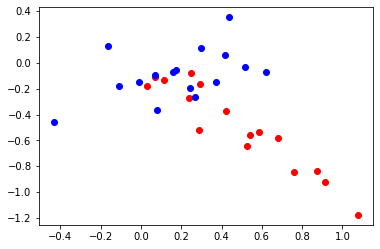

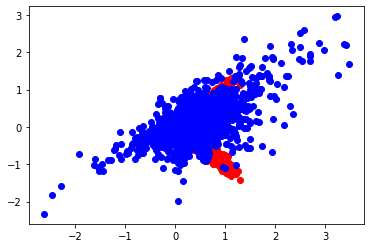

399 0.8500000238418579 1.0


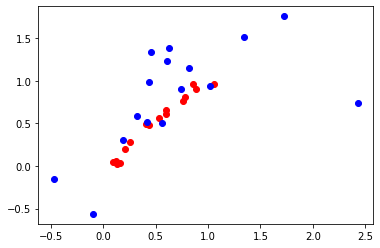

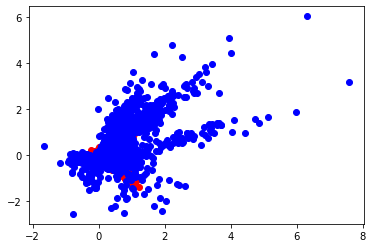

599 0.7200000286102295 0.8500000238418579


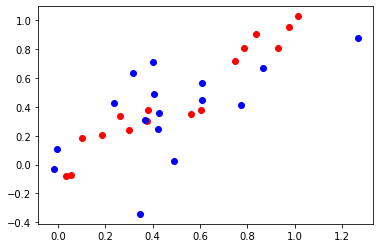

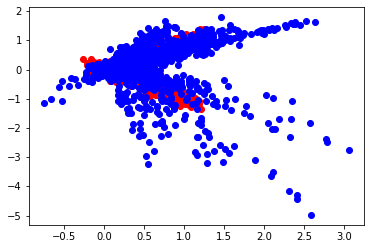

799 0.6399999856948853 0.5


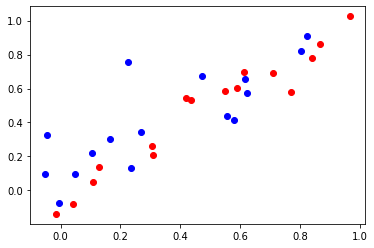

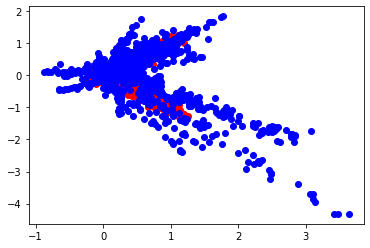

999 0.6800000071525574 0.7599999904632568


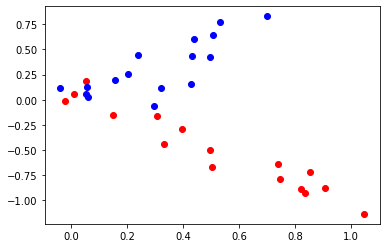

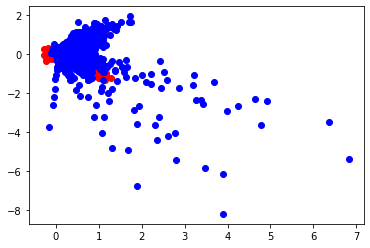

1199 0.4399999976158142 0.8500000238418579


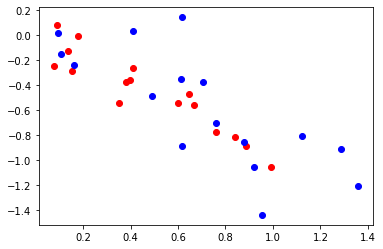

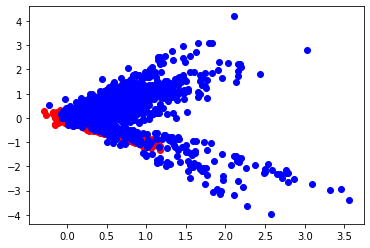

1399 0.6899999976158142 0.7900000214576721


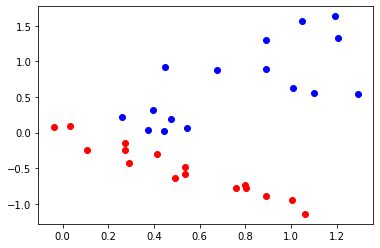

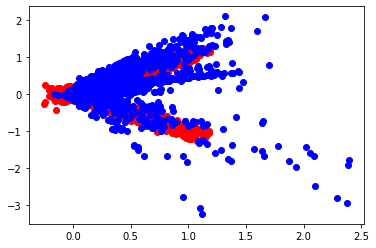

1599 0.5600000023841858 0.8199999928474426


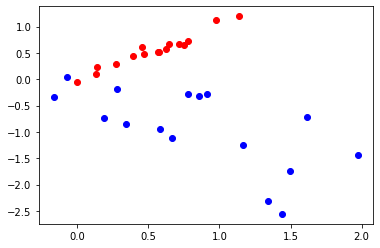

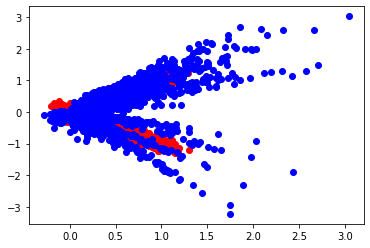

1799 0.4300000071525574 0.8299999833106995


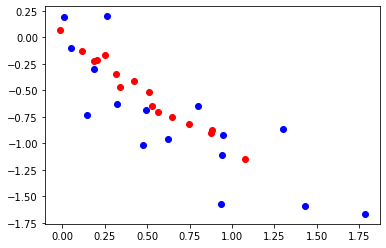

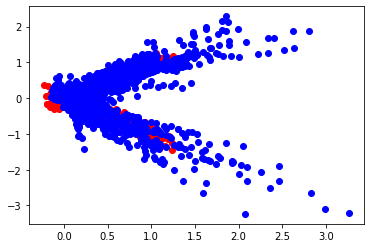

1999 0.6000000238418579 0.8299999833106995


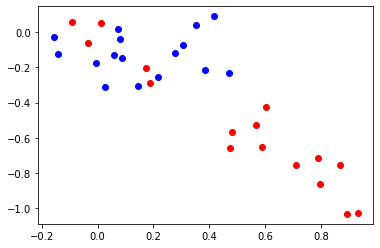

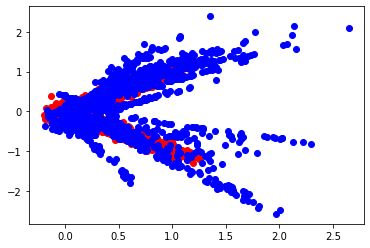

2199 0.4300000071525574 0.8600000143051147


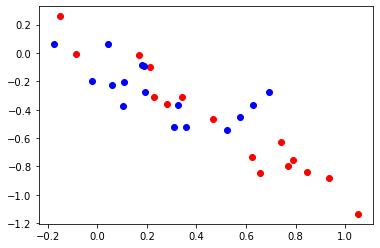

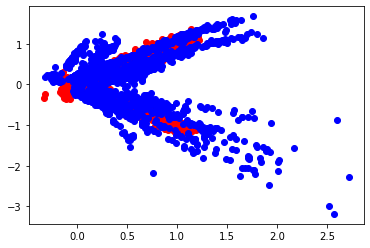

2399 0.7300000190734863 0.8500000238418579


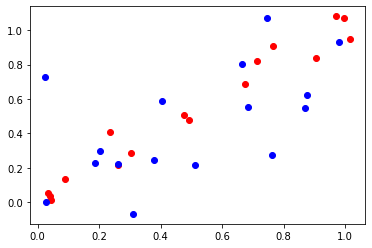

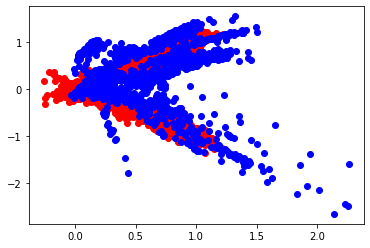

2599 0.6399999856948853 0.46000000834465027


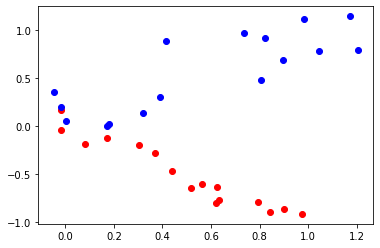

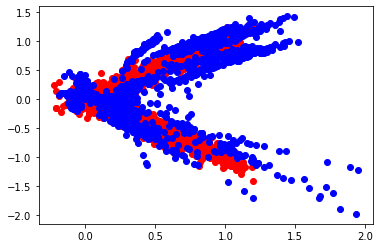

2799 0.5600000023841858 0.7699999809265137


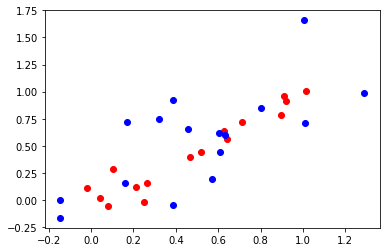

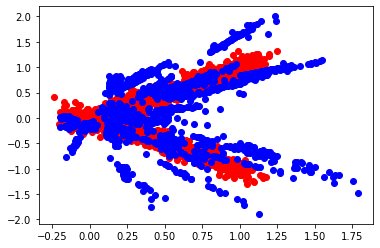

2999 0.550000011920929 0.8500000238418579


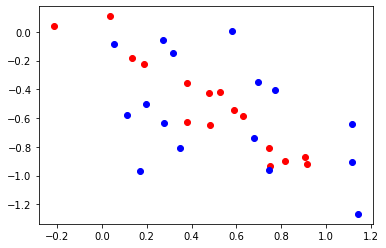

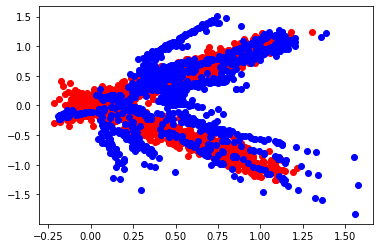

3199 0.9599999785423279 0.4300000071525574


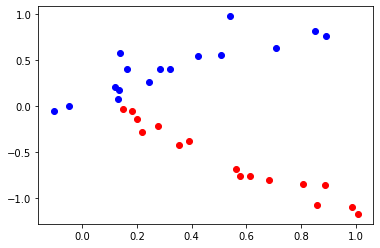

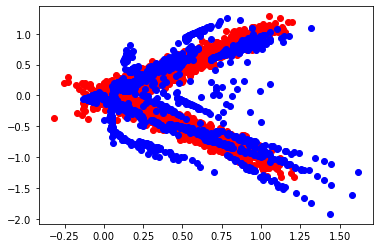

3399 0.4300000071525574 0.7400000095367432


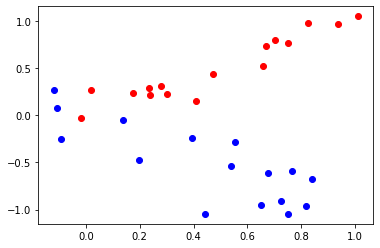

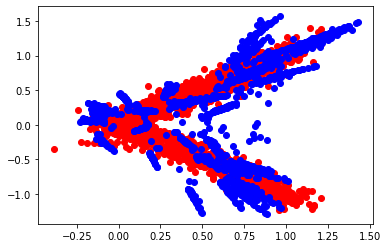

3599 0.6200000047683716 0.6800000071525574


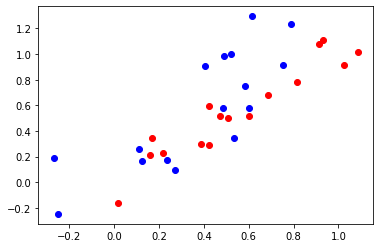

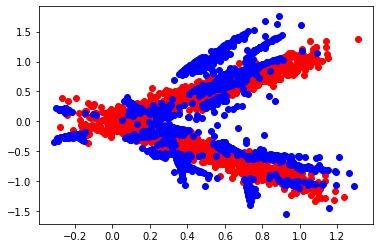

3799 0.6499999761581421 0.6600000262260437


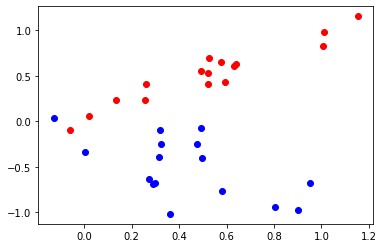

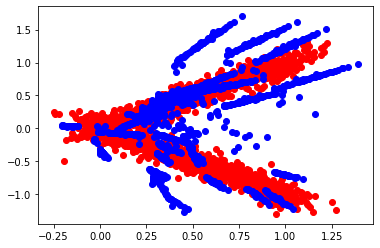

3999 0.7200000286102295 0.5299999713897705


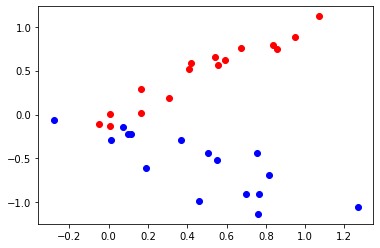

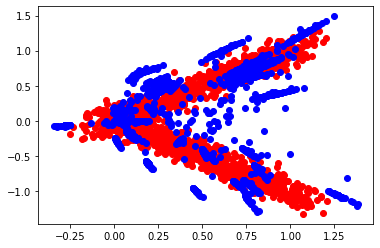

4199 0.5299999713897705 0.6100000143051147


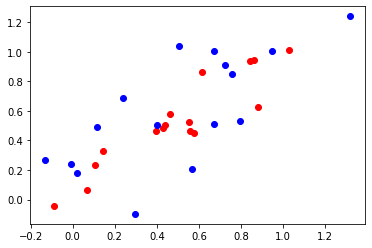

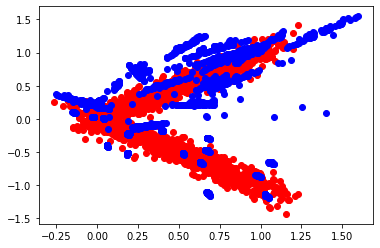

4399 0.41999998688697815 0.6000000238418579


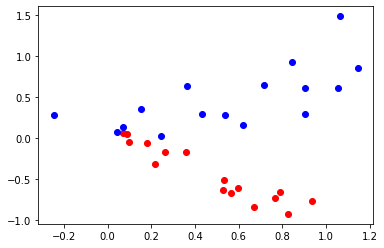

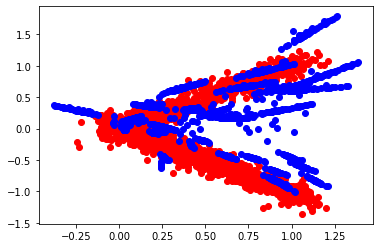

4599 0.6399999856948853 0.8600000143051147


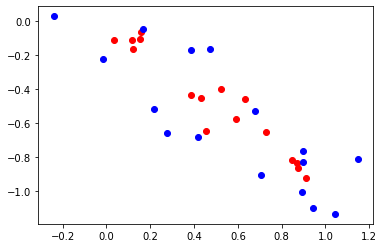

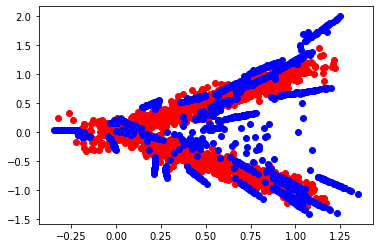

4799 0.5799999833106995 0.6700000166893005


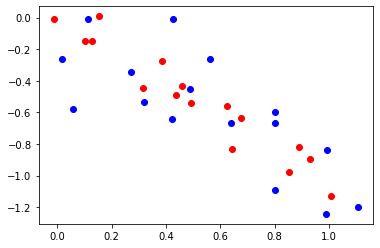

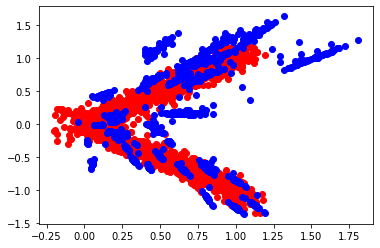

4999 0.7300000190734863 0.15000000596046448


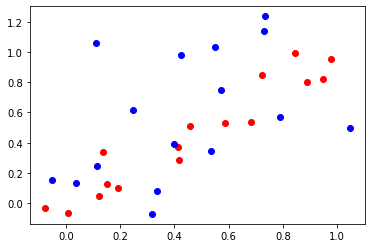

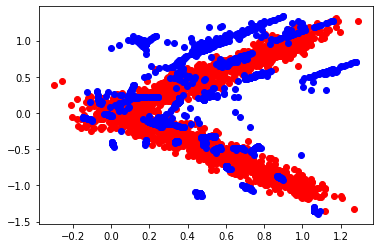

5199 0.6899999976158142 0.4300000071525574


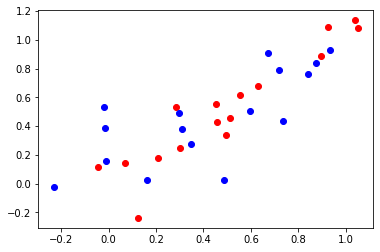

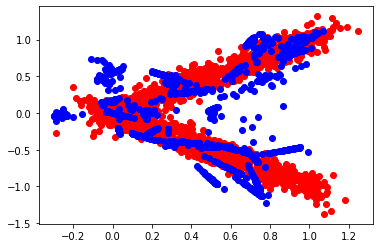

5399 0.5299999713897705 0.5899999737739563


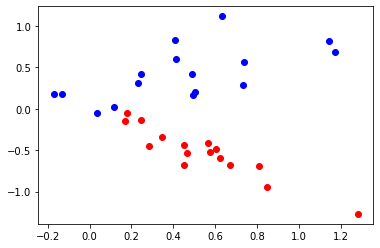

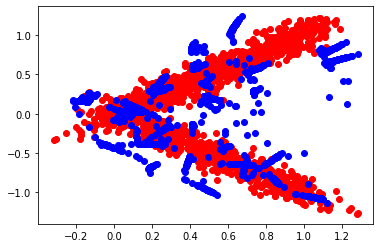

5599 0.38999998569488525 0.550000011920929


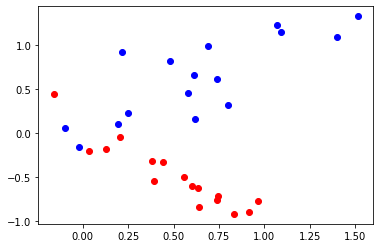

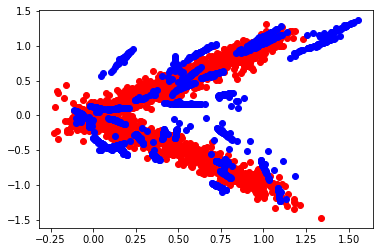

5799 0.4399999976158142 0.47999998927116394


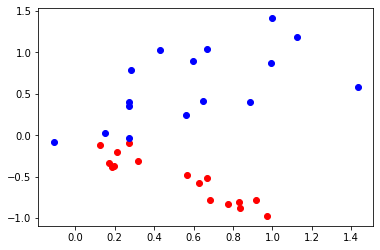

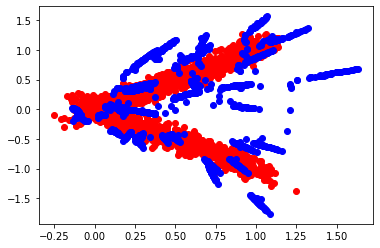

5999 0.6200000047683716 0.7099999785423279


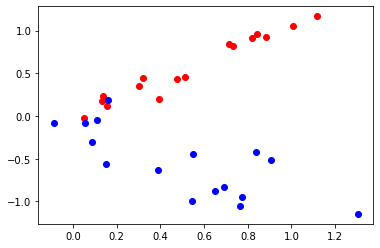

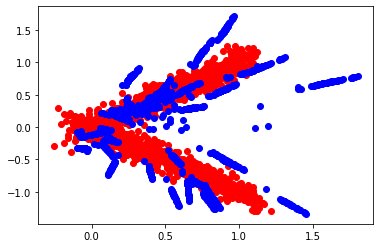

6199 0.6000000238418579 0.6299999952316284


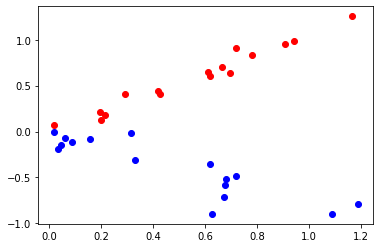

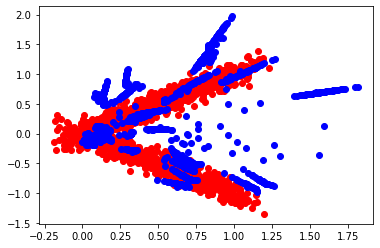

6399 0.4099999964237213 0.5299999713897705


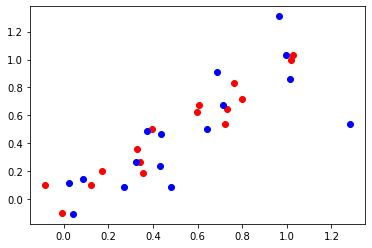

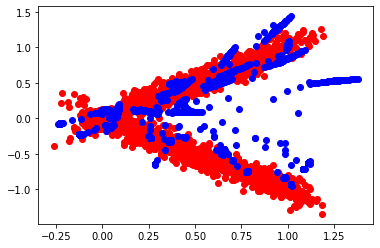

6599 0.7300000190734863 0.46000000834465027


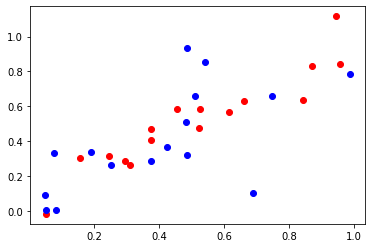

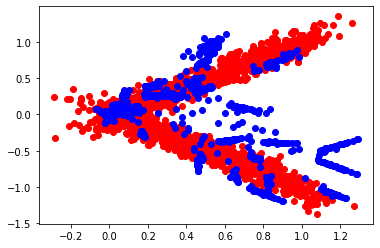

6799 0.4099999964237213 0.029999999329447746


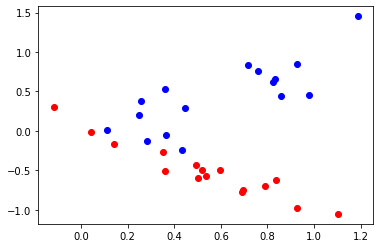

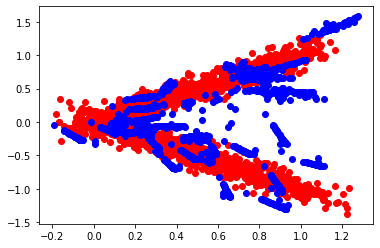

6999 0.5899999737739563 0.5400000214576721


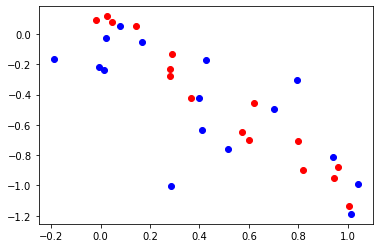

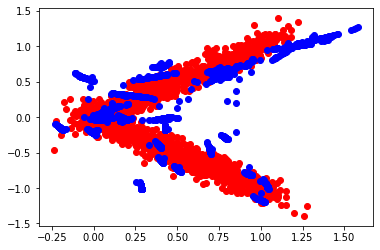

7199 0.7200000286102295 0.44999998807907104


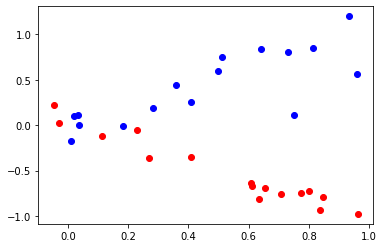

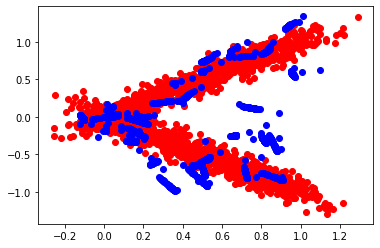

7399 0.4399999976158142 0.33000001311302185


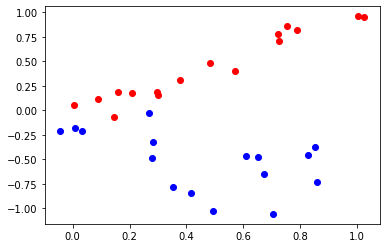

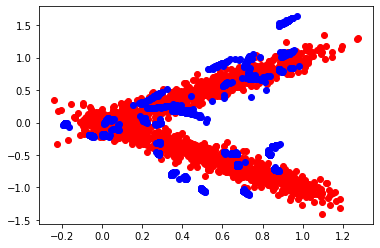

7599 0.3100000023841858 0.550000011920929


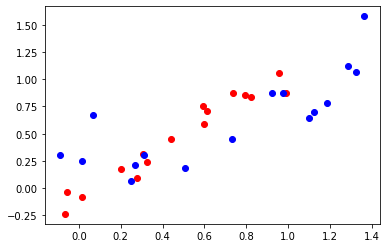

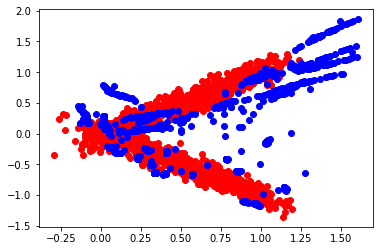

7799 0.6200000047683716 0.5400000214576721


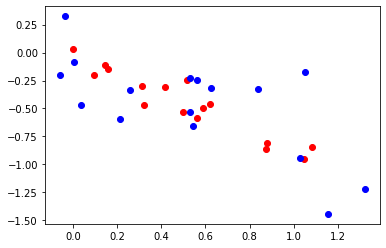

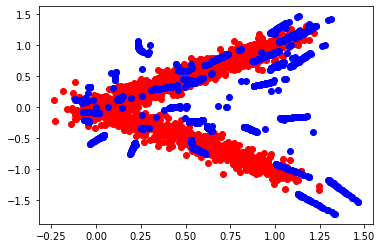

7999 0.46000000834465027 0.699999988079071


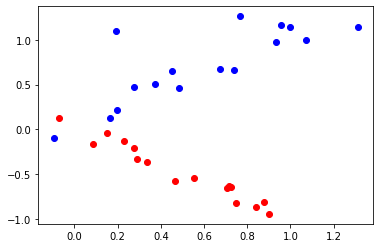

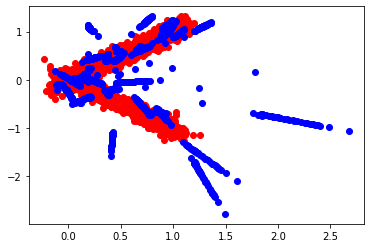

8199 0.5 0.8199999928474426


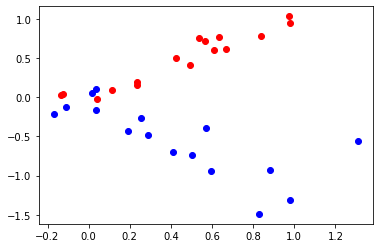

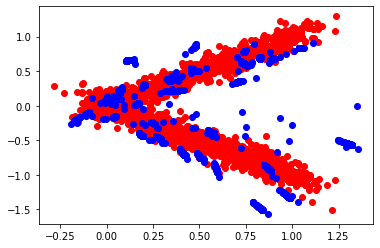

8399 0.5400000214576721 0.6700000166893005


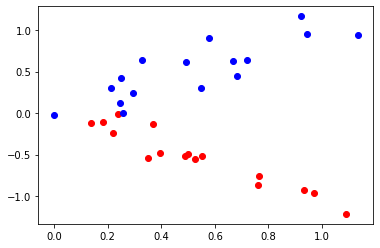

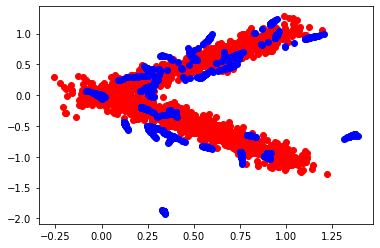

8599 0.5099999904632568 0.6899999976158142


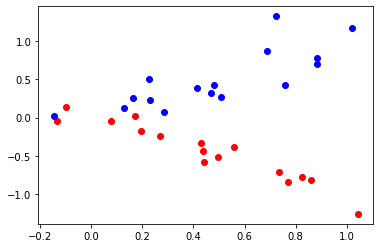

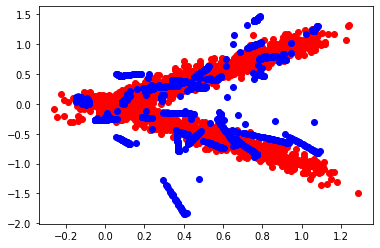

8799 0.8899999856948853 0.20999999344348907


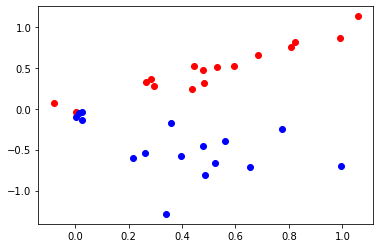

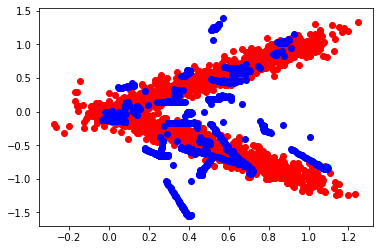

8999 0.6299999952316284 0.7300000190734863


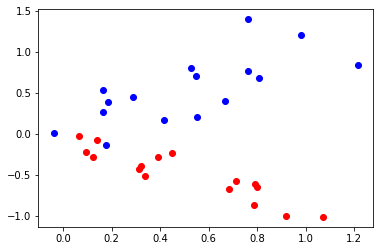

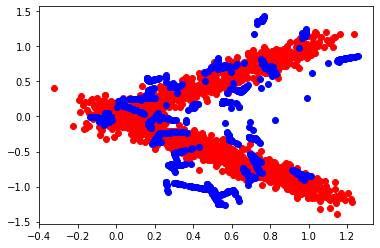

9199 0.5600000023841858 0.4300000071525574


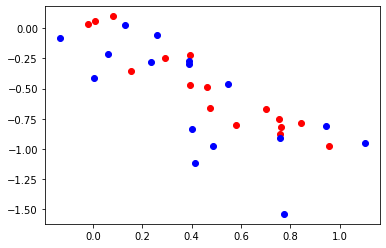

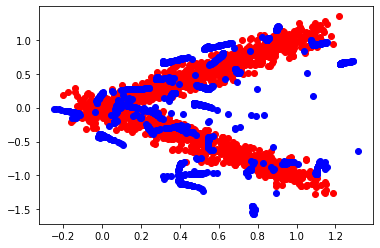

9399 0.75 0.7599999904632568


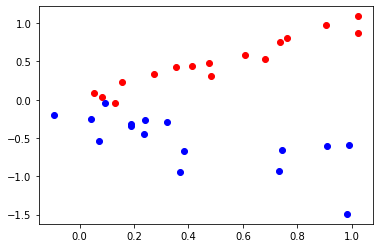

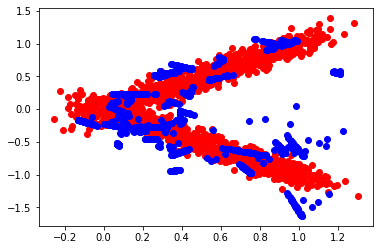

9599 0.33000001311302185 0.5699999928474426


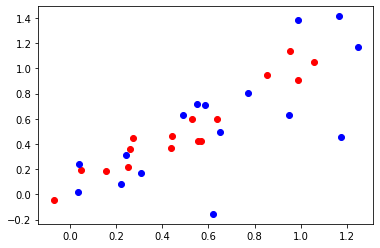

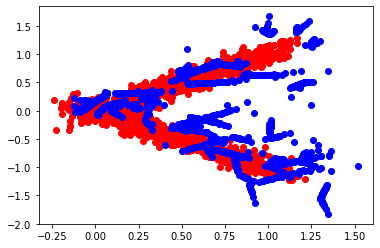

9799 0.5099999904632568 0.1599999964237213


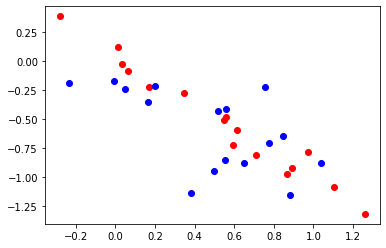

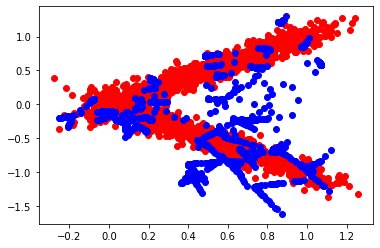

9999 0.8399999737739563 0.029999999329447746


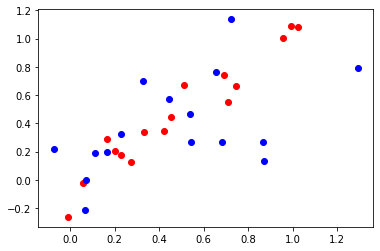

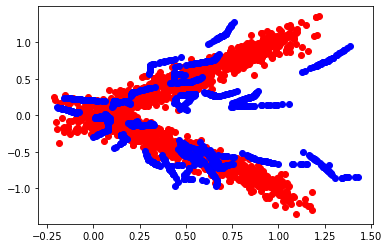

In [30]:

# size of the latent space
latent_dim = 256
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)